## Исследование объявлений о продаже квартир
#### В нашем распоряжении данные сервиса Яндекc Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Наша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 
#### По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Изучим данных из файла

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df=pd.read_csv('real_estate_data.csv',sep='\t')
display(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

None

#### В датасете есть 22 колонки данных, из них пропуски имеются в: 
* ceiling_height (высота потолка), 
* living_area (жилая площадь квартиры), 
* floors_total (общее кол-во этажей), 
* is_apartment (отметка является ли квартира - апартаментами), 
* kitchen_area (площадь кухни), balcony (кол-во балконов), 
* locality_name (название местности), 
* airports_nearest (расстояние до ближайшего аэропорта), 
* cityCenters_nearest (расстояние до центра города), 
* parks_around3000 (кол-во парков вблизи), 
* parks_nearest (расстояние до ближайшего парка), 
* ponds_around3000 (кол-во прудов рядом), 
* ponds_nearest (расстояние до ближайшего пруда), 
* days exposition (кол-во дней сколько квартира продавалась)

### Предобработка данных
#### Изменим следующие типы данных: 
* first_day_exposition на data,
* floors_total на int,
* balcony на int, 
* parks_around3000 на int, 
* ponds_around3000 на int. 
#### Также заполним пропуски: 
* В balcony заменим на 0, т.к. если человек не указал число балконов — скорее всего, их нет.
* В ceiling_height пропуски можно заполнить медианным значением по всему датасету, т.к. такой метод устойчив к выбросам. 
* В floors_total пропусков мало (всего 86): их можно восстановить, однако у нас такой возможности нет — поэтому заменим значения медианой по всему датасету. 
* В airports_nearest, cityCenters_nearest, parks_nearest, ponds_nearest пропуски, вероятно, означают, что в радиусе поиска не оказалось такого объекта: логичнее всего заменить их на очень большое число (например, 99999). 
* В parks_around3000, ponds_around3000 аналогично, пропуск, скорее всего, означает 0 объектов: заменяем на 0. 
* В is_apartment от пропусков избавиться не получиться, ведь это категориальный признак с огромным количеством пропусков (20k+ из 23k!), даже если предположить что пропуск, скорее всего, означает "Нет", то после заполнения 90% значений будут "Нет" что не будет информотивно. 
* В living_area и kitchen_area от пропусков не получиться избавиться, ведь заполниение медианой иди средним создает статистические артефакты и скрывает потенциально важные закономерности. 

In [2]:
df['floors_total']=df['floors_total'].fillna(value=df['floors_total'].median())
df['floors_total']=df['floors_total'].astype(dtype='int',errors='ignore')

df['balcony']=df['balcony'].fillna(0)
df['balcony']=df['balcony'].astype(dtype='int')

df['parks_around3000']=df['parks_around3000'].fillna(0)
df['parks_around3000']=df['parks_around3000'].astype('int')

df['ponds_around3000']=df['ponds_around3000'].fillna(0)
df['ponds_around3000']=df['ponds_around3000'].astype('int')

df['first_day_exposition']=pd.to_datetime(df['first_day_exposition'])

df['ceiling_height']=df['ceiling_height'].fillna(df['ceiling_height'].median())

list_of_faraway=['airports_nearest', 'parks_nearest', 'ponds_nearest','cityCenters_nearest']
for i in list_of_faraway:
    df[i]=df[i].fillna(99999)

df['parks_nearest']=df['parks_nearest'].astype('int')

df['ponds_nearest']=df['ponds_nearest'].astype('int')

display(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23699 non-null  int64         
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          2775 non-null   object        
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

None

### Расчёты и добавление результатов в таблицу
#### Добавим в таблицу: 
* цену квадратного метра; 
* день недели, месяц и год публикации объявления
* этаж квартиры: варианты — первый, последний, другой
* соотношение жилой и общей площади, а также отношение площади кухни к общей

In [13]:
df['price_meter']=df['last_price']/df['total_area']

df['day_of_week']=df['first_day_exposition'].dt.dayofweek

df['month']=df['first_day_exposition'].dt.month

df['year']=df['first_day_exposition'].dt.year

def floor_type(x):
    if x['floor']==1:
        return -1#'first'
    elif x['floor']==x['floors_total']:
        return 1 #"last"
    else:
        return 0#"another"

df['floor_type']=df.apply(lambda x: floor_type(x),axis=1)

df['ratio_of_living']=df['living_area']/df['total_area']

df['ratio_of_kitchen']=df['kitchen_area']/df['total_area']

display(df.head())

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,price_meter,day_of_week,mounth,year,floor_type,ratio_of_living,ratio_of_kitchen,month
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,NaN,...,755,NaN,120370.370370,3,3,2019,0,0.472222,0.231481,3
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.6,1,NaN,...,99999,81.0,82920.792079,1,12,2018,-1,0.460396,0.272277,12
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,NaN,...,574,558.0,92785.714286,3,8,2015,0,0.612500,0.148214,8
3,0,64900000.0,159.0,2015-07-24,3,2.65,14,NaN,9,NaN,...,234,424.0,408176.100629,4,7,2015,0,NaN,NaN,7
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,NaN,...,48,121.0,100000.000000,1,6,2018,0,0.320000,0.410000,6


### Исследовательский анализ данных
#### Изучим следующие параметры: площадь, цена, число комнат, высота потолков. Построем гистограммы для каждого параметра.

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

Процент квартир с площадью > 200 м^2: 0.96


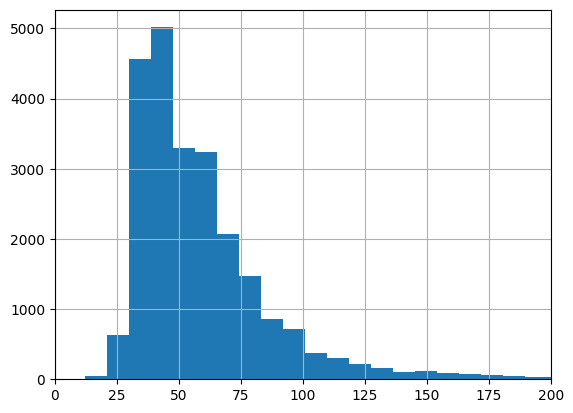

count        23699.0
mean       6541548.8
std       10887013.3
min          12190.0
25%        3400000.0
50%        4650000.0
75%        6800000.0
max      763000000.0
Name: last_price, dtype: float64

Процент квартир с ценой > 35 миллионов: 1.04


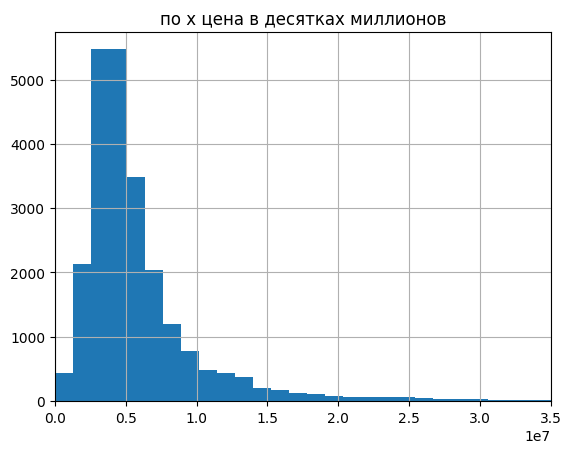

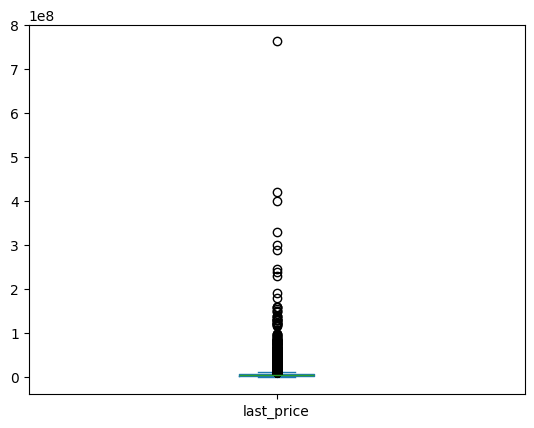

count    23699.000000
mean         2.070636
std          1.078405
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

Процент квартир с кол-вом комнат > 5: 0.82


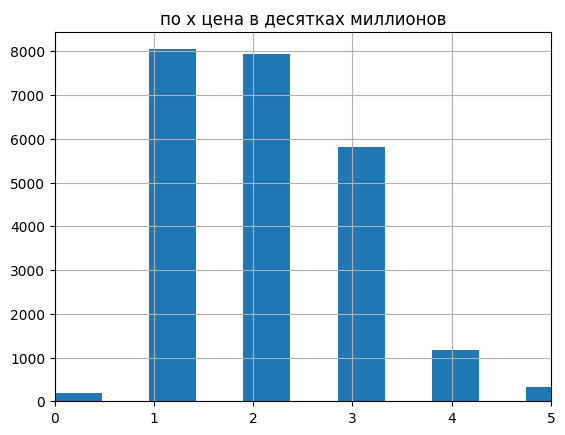

count    23699.000000
mean         2.724358
std          0.988298
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

Процент квартир с потолком > 3.6: 0.95


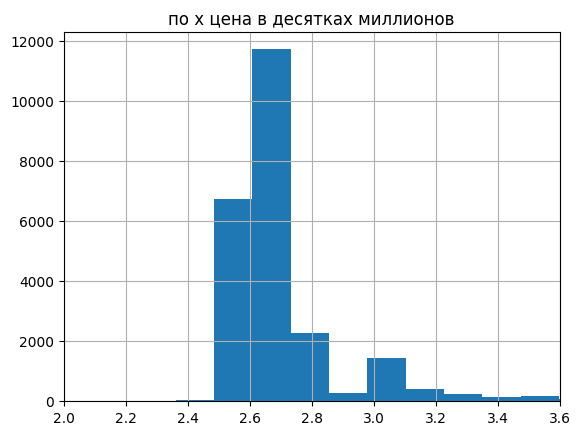

In [4]:
display(df['total_area'].describe())
print('Процент квартир с площадью > 200 м^2:',(df.loc[df['total_area']>200,'total_images'].count()/len(df)*100).round(2))
#в площади есть выбросы как будто можно удалить площадь>200 таких значенй <1% от общего кол-ва
df['total_area'].hist(bins=100)
plt.xlim(0,200)
plt.show()

display(df['last_price'].describe().round(1))
print('Процент квартир с ценой > 35 миллионов:',(df.loc[df['last_price']>35000000,'total_images'].count()/len(df)*100).round(2))
#в цене есть выбросы как будто можно удалить цены>35000000 таких значенй ~1% от общего кол-ва
df['last_price'].hist(bins=600)
plt.xlim(0,35000000)
plt.title('по х цена в десятках миллионов')
plt.show()
df['last_price'].plot(kind='box')
plt.show()

display(df['rooms'].describe())
print('Процент квартир с кол-вом комнат > 5:',(df.loc[df['rooms']>5,'total_images'].count()/len(df)*100).round(2))
#в кол-ве комнат есть выбросы как будто можно удалить комнаты>5 таких значенй <1% от общего кол-ва
df['rooms'].hist(bins=40)
plt.xlim(0,5)
plt.title('по х цена в десятках миллионов')
plt.show()

display(df['ceiling_height'].describe())
print('Процент квартир с потолком > 3.6:',(df.loc[df['ceiling_height']>3.6,'total_images'].count()/len(df)*100).round(2))
#в высоте потолка есть выбросы как будто можно удалить потолки>3.6 таких значенй <1% от общего кол-ва
df['ceiling_height'].hist(bins=800)
plt.xlim(2,3.6)
plt.title('по х цена в десятках миллионов')
plt.show()



#### Изучим как влияет время которое проводит квартира на сайте объявлений на продажу квартиры
* Построем гистограмму; 
* Посчитаем среднее и медиану. 
* Опишем, сколько обычно занимает продажа. 
* Определим когда можно считать, что продажи прошли очень быстро, а когда необычно долго? 

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

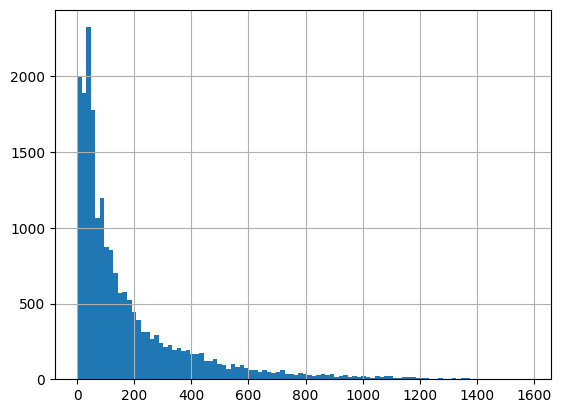

Медиана по дням продажи =  95.0
Ср. ариф.  по дням продажи =  180.88863436982163


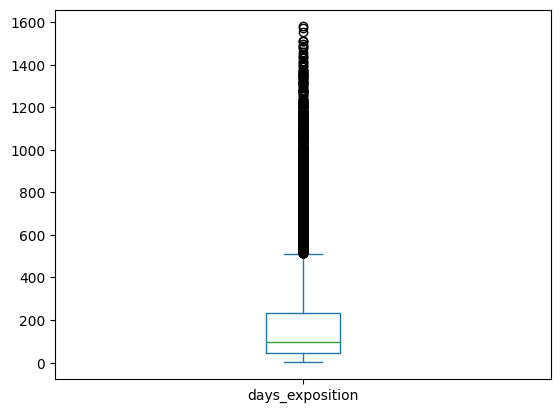

Процент значений в датасете больше границы выброса (>512.5):  7.042491244356302


In [5]:
display(df['days_exposition'].describe())
df['days_exposition'].hist(bins=100)
plt.show()

median_days=df['days_exposition'].median()
mean_days=df['days_exposition'].mean()
print('Медиана по дням продажи = ',median_days)
print('Ср. ариф.  по дням продажи = ',mean_days)

df['days_exposition'].plot(kind='box')
plt.show()

print('Процент значений в датасете больше границы выброса (>512.5): ',df.loc[df['days_exposition']>512.5,'total_images'].count()/len(df)*100)

#### Что считать быстрой продажей?
* Очень быстро: до 45 дней (нижние 25%)
* Быстро: до 95 дней (быстрее медианы)

#### Что считать необычно долгой продажей?
* Медленно: более 232 дней (верхние 25%)
* Критически долго: более 512 дней (статистические выбросы)

#### Сколько обычно занимает продажа?
* От 45 (1 квантиль) до 232 (3 квантиль)
* "Чаще всего" (медиана): 3 месяца

### Уберём редкие и выбивающиеся значения. Опишем, какие особенности обнаружили.
#### Обнаруженные аномалии:
* Потолок выше 3.6 метров явная аномалия 
* Цена на квартиру < 1 миллиона является ошибкой
* Есть квартира что находиться в аэропорту

In [6]:
df=df[df['ceiling_height']<3.7]
df=df[df['last_price']>1000000]
df=df[df['airports_nearest']>0]
display(df.describe().round(1))


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,...,ponds_around3000,ponds_nearest,days_exposition,price_meter,day_of_week,mounth,year,floor_type,ratio_of_living,ratio_of_kitchen
count,23245.0,23245.0,23245.0,23245,23245.0,23245.0,23245.0,21397.0,23245.0,21032.0,...,23245.0,23245.0,20157.0,23245.0,23245.0,23245.0,23245.0,23245.0,21397.0,21032.0
mean,9.9,6462115.1,60.0,2017-11-08 15:05:45.209722368,2.1,2.7,10.8,34.2,5.9,10.5,...,0.6,61572.1,180.3,99762.8,2.6,6.4,2017.4,0.0,0.6,0.2
min,0.0,1010000.0,12.0,2014-11-27 00:00:00,0.0,1.0,1.0,2.0,1.0,1.3,...,0.0,13.0,1.0,10507.2,0.0,1.0,2014.0,-1.0,0.0,0.0
25%,6.0,3450000.0,40.0,2017-05-12 00:00:00,1.0,2.6,5.0,18.6,2.0,7.0,...,0.0,634.0,45.0,77235.8,1.0,3.0,2017.0,0.0,0.5,0.1
50%,9.0,4650000.0,52.0,2017-12-12 00:00:00,2.0,2.6,9.0,30.0,4.0,9.2,...,0.0,99999.0,95.0,95176.0,3.0,6.0,2017.0,0.0,0.6,0.2
75%,14.0,6750000.0,69.6,2018-08-25 00:00:00,3.0,2.7,16.0,42.2,8.0,12.0,...,1.0,99999.0,230.0,114209.8,4.0,10.0,2018.0,0.0,0.6,0.2
max,50.0,763000000.0,900.0,2019-05-03 00:00:00,19.0,3.7,60.0,409.7,33.0,112.0,...,3.0,99999.0,1580.0,1907500.0,6.0,12.0,2019.0,1.0,1.0,0.8
std,5.7,10462980.1,34.2,NaN,1.1,0.2,6.6,21.0,4.9,5.8,...,0.9,48437.8,219.3,48766.3,1.8,3.5,1.0,0.5,0.1,0.1


### Какие факторы больше всего влияют на стоимость квартиры? 
#### Изучим, зависит ли цена от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра.

,last_price,total_area
last_price,1.000000,0.783688
total_area,0.783688,1.000000


,last_price,rooms
last_price,1.000000,0.485197
rooms,0.485197,1.000000


,last_price,floor_type
last_price,1.000000,0.056787
floor_type,0.056787,1.000000


,last_price,cityCenters_nearest
last_price,1.000000,-0.397934
cityCenters_nearest,-0.397934,1.000000


,price_meter,cityCenters_nearest
price_meter,1.000000,-0.556601
cityCenters_nearest,-0.556601,1.000000


,last_price,total_area,cityCenters_nearest,rooms
last_price,1.000000,0.779953,-0.405147,0.476415
total_area,0.779953,1.000000,-0.188584,0.782609
cityCenters_nearest,-0.405147,-0.188584,1.000000,-0.118820
rooms,0.476415,0.782609,-0.118820,1.000000


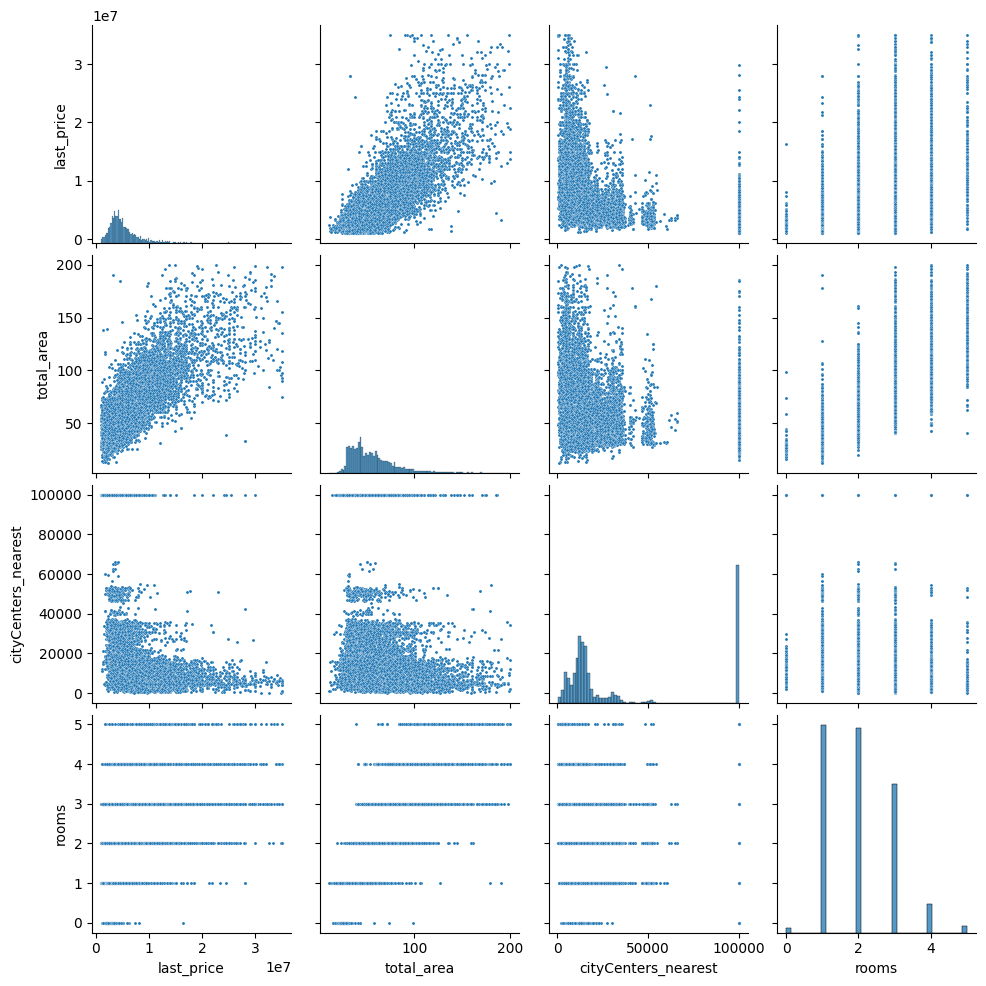

In [7]:
display((df.loc[(df['total_area']<=200)&(df['last_price']<=35000000),'last_price':'total_area']).corr())

display((df.loc[(df['rooms']<=5)&(df['last_price']<=35000000),['last_price','rooms']]).corr())

display((df.loc[(df['last_price']<=35000000),['last_price','floor_type']]).corr())

display((df.loc[(df['last_price']<=35000000),['last_price','cityCenters_nearest']]).corr())

display((df.loc[(df['last_price']<=35000000),['price_meter','cityCenters_nearest']]).corr())

# Множественная корреляция
display(df.loc[(df['last_price']<=35000000)&(df['total_area']<=200)&(df['rooms']<=5),['last_price', 'total_area', 'cityCenters_nearest', 'rooms']].corr())

sns.pairplot(df.loc[(df['last_price']<=35000000)&(df['total_area']<=200)&(df['rooms']<=5),['last_price', 'total_area', 'cityCenters_nearest', 'rooms']],plot_kws={'s': 5})

### Некоторые выводы:
* корреляция между ценой и площадью составила 0.784: это сильная положительная связь. Интерпритация: увеличение площади почти линейно увеличивает стоимость квартиры;
* корреляция между числом комнат и ценой составила 0.485: это умеренная положительная связь. Интерпритация: количество комнат не всегда напрямую связано с площадью (есть квартиры с разной планировкой), поэтому и влияние этого фактора на цену меньше;
* корреляция между типом этажа и ценой составила 0.057: очень слабая, почти отсутствующая связь. Интерпитация: в данных нет выраженного ценового преимущества у определенных типов этажей;
* корееляци между удаленностью от центра и ценой равна -0.398: ёто умеренная отрицательная связь. Интерпритация: чем дальше от центра тем ниже цена;
* корееляци между удаленностью от центра и ценой за квадратный метр равна -0.557: связь значительно усилилась по сравнению с общей ценой. Интерпритация: Локация влияет в первую очередь на стоимость квадратного метра, а не на общую площадь квартиры.
* Множественная корреляция демонстрирует похожие результаты: 
    * Площадь vs Цена: 0.780
    * Удаленность от центра vs Цена: -0.405
    * Комнаты vs Цена: 0.476
* Для анализа использовались данные без выбросов:
    * площадь <200 м^2,
    * цена квартиры <35 миллионов,
    * количество комнат <=5.

#### Также изучим зависимость цены от даты размещения: дня недели, месяца и года


In [14]:
display((df.loc[(df['last_price']<=35000000),['last_price','day_of_week']]).corr())

display((df.loc[(df['last_price']<=35000000),['last_price','mounth']]).corr())

display((df.loc[(df['last_price']<=35000000),['last_price','year']]).corr())


,last_price,day_of_week
last_price,1.000000,-0.013955
day_of_week,-0.013955,1.000000


,last_price,mounth
last_price,1.000000,-0.000058
mounth,-0.000058,1.000000


,last_price,year
last_price,1.000000,-0.035275
year,-0.035275,1.000000


#### Некоторые выводы:
* Корреляции практически нулевые:
    * День недели: -0.014 ≈ 0

    * Месяц: -0.000058 ≈ 0

    * Год: -0.035 ≈ 0
* Интерпритация: время размещения объявления НЕ влияет на цену квартиры



### Определим населенные пункты лидеры по кол-ву обявлений и по стоимости квадартного метра.
#### Выберем 10 населённых пунктов с наибольшим числом объявлений. Посчитаем среднюю цену квадратного метра в этих населённых пунктах. Выделим населённые пункты с самой высокой и низкой стоимостью жилья. 

In [9]:
display(df.head())
local_df=(df.pivot_table(index='locality_name',values=['price_meter','total_area'],aggfunc={'total_area':'count','price_meter':'mean'}))
local_df.columns=['price_meter','obyavleniya']


local_df=local_df.sort_values(by='obyavleniya',ascending=False)

display(local_df.head(10))

display(local_df.describe())

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_meter,day_of_week,mounth,year,floor_type,ratio_of_living,ratio_of_kitchen
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,NaN,...,2,755,NaN,120370.370370,3,3,2019,0,0.472222,0.231481
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.6,1,NaN,...,0,99999,81.0,82920.792079,1,12,2018,-1,0.460396,0.272277
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,NaN,...,2,574,558.0,92785.714286,3,8,2015,0,0.612500,0.148214
3,0,64900000.0,159.0,2015-07-24,3,2.65,14,NaN,9,NaN,...,3,234,424.0,408176.100629,4,7,2015,0,NaN,NaN
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,NaN,...,1,48,121.0,100000.000000,1,6,2018,0,0.320000,0.410000


,price_meter,obyavleniya
locality_name,,
Санкт-Петербург,114261.601743,15542
посёлок Мурино,85725.241381,520
посёлок Шушары,78655.103087,439
Всеволожск,68617.025644,395
Пушкин,102605.317177,364
Колпино,75424.579098,338
посёлок Парголово,90175.913458,327
Гатчина,69001.879200,304
деревня Кудрово,92473.547576,299


,price_meter,obyavleniya
count,332.000000,332.000000
mean,48633.539067,69.870482
std,19470.641320,854.144521
min,15648.286140,1.000000
25%,34099.156508,1.000000
50%,44731.346555,4.000000
75%,58917.520310,11.000000
max,121616.221359,15542.000000


#### Выводы:
* Явный лидер по объёму рынка - Санкт-Петербург доминирует с огромным отрывом: 15 542 объявления, что более чем в 30 раз превышает показатели следующего за ним населённого пункта. Это подтверждает статус города как крупнейшего рынка недвижимости в регионе.

* Высокая концентрация спроса в пригородах - В топ-10 вошли преимущественно населённые пункты-спутники Санкт-Петербурга (Мурино, Шушары, Всеволожск, Пушкин, Колпино и др.), что свидетельствует о активном развитии пригородной зоны и миграции спроса на жильё в более доступные районы.

* Значительный разброс цен - Наблюдается существенная дифференциация стоимости жилья:

    * Максимальная средняя цена в Санкт-Петербурге - 114 262 руб./м²

    * Минимальная - в Выборге - 58 644 руб./м²

* Разница составляет почти 2 раза, что демонстрирует различную инвестиционную привлекательность и уровень развития инфраструктуры.

* Ценовой тренд - Наиболее близкие к Санкт-Петербургу пригороды (Мурино, Парголово, Кудрово) демонстрируют более высокие цены по сравнению с более удалёнными территориями, что подтверждает зависимость стоимости недвижимости от транспортной доступности и близости к мегаполису.

### Изучим предложения квартир
#### Для каждой квартиры есть информация о расстоянии до центра. Выделим квартиры в Санкт-Петербурге (locality_name). Наша задача — выяснить, какая область входит в центр. Создим столбец с расстоянием до центра в километрах: округлим до целых значений. После этого посчитаем среднюю цену для каждого километра. Построем график: он должен показывать, как цена зависит от удалённости от центра. Определим границу, где график сильно меняется, — это и будет центральная зона.

,price_meter
distance,
0.0,255150.738738
1.0,175427.416644
2.0,153623.621969
3.0,120882.846415
4.0,132862.620161
5.0,139552.990732
6.0,149653.670199
7.0,155989.669936
8.0,124787.681618


np.float64(90.60537313432836)

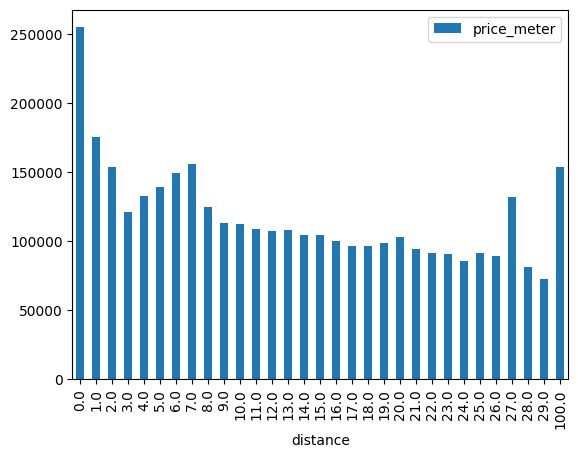

In [10]:
piter_df=(df[df['locality_name']=='Санкт-Петербург'])
piter_df=(piter_df.loc[piter_df['cityCenters_nearest'].isna()==False])

piter_df['distance']=(piter_df['cityCenters_nearest']/1000).round(0)

itog_po_distance=(piter_df.pivot_table(index='distance',values='price_meter',aggfunc='mean'))

display(itog_po_distance)

itog_po_distance.plot(kind='bar')

display(piter_df.loc[piter_df['distance']==3,'total_area'].mean())

#### Вывод - Граница центральной зоны: 3-4 км
#### Объяснение:
* 0-3 км: Цена резко падает с 255 тыс. до 120 тыс. руб./м²
* На 4 км: Происходит значительное изменение тренда
* После 4 км: Цена стабилизируется в диапазоне 100-140 тыс. руб./м² 
#### В данных наблюдается рост цены после 4 км, и это можно оъяснить следующим:
* Влияние престижных локаций:
    * Василеостровский район (4-6 км от центра)
    * Приморский район (5-7 км) - новые ЖК бизнес-класса
    * Петроградская сторона (3-5 км) - историческая застройка
* Качество и тип недвижимости
* Транспортная инфраструктура:
    * Близость к станциям метро после 4 км
    * Наличие парков и водоемов
    * Развитая социальная инфраструктура

### Анализ квартир в центре
#### Выделим сегмент квартир в центре. Проанализируем эту территорию и изучим следующие параметры: площадь, цена, число комнат, высота потолков. Также выделим факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделаем выводы. Определим отличаются ли они от общих выводов по всей базе.

In [11]:
centr=[0,1,2,3]
centr_piter_df=(piter_df[piter_df['distance'].isin(centr)])

display(centr_piter_df['total_area'].describe())

display(centr_piter_df['last_price'].describe().round(1))

display(centr_piter_df['rooms'].describe())

display(centr_piter_df['ceiling_height'].describe())


count    820.000000
mean      98.164171
std       55.607046
min       12.000000
25%       63.300000
50%       85.000000
75%      115.475000
max      517.000000
Name: total_area, dtype: float64

count          820.0
mean      15920140.2
std       26355873.7
min        2100000.0
25%        7200000.0
50%        9595000.0
75%       14562500.0
max      401300000.0
Name: last_price, dtype: float64

count    820.000000
mean       3.128049
std        1.482315
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max       14.000000
Name: rooms, dtype: float64

count    820.000000
mean       2.975610
std        0.323922
min        2.500000
25%        2.650000
50%        3.000000
75%        3.200000
max        3.680000
Name: ceiling_height, dtype: float64


#### Aнализ наглядно показывает, что квартиры в центре Санкт-Петербурга являются премиальным сегментом и существенно отличаются от средних показателей по городу:
1. Площадь: 
    * Медиана по городу = 52 м^2
    * Медиана в центре = 85 м^2
    * В центре продаются в основном большие, просторные квартиры.
2. Число комнат:
    * Медианое число комнат по городу = 2 
    * Медианое число комнат в центре = 3 
    * Предложение в центре ориентировано на многокомнатные квартиры, что логично сочетается с их большей площадью.
3. Цена:
    * Медианая цена по городу = 4.65 млн 
    * Медианая цена в центре = 9.60 млн
    * Центр — самый дорогой сегмент рынка.
4. Высота потолков:
    * Медианая высота потолка по городу = 3.00 м
    * Медианая высота потолка в центре = 2.65 м
    * Высокие потолки — одна из ключевых характеристик и преимуществ жилья в центре Петербурга.
#### Квартиры в центре Санкт-Петербурга кардинально отличаются от средних показателей по рынку и формируют элитный сегмент недвижимости. Они характеризуются:
* Большей площадью (в среднем на 60% больше).
* Значительно более высокой ценой (в 2-2.5 раза дороже).
* Большим числом комнат (преобладают трех- и четырехкомнатные).
* Существенно более высокими потолками (3 метра против 2.65 в среднем по городу).

### Анализ корреляции
#### Какие факторы из описанных далле больше всего влияют на стоимость квартиры в центре? Изучим, зависит ли цена от числа комнат, этажа, удалённости от центра и даты размещения объявления.

In [12]:
display(centr_piter_df.loc[(df['last_price']<=35000000),['last_price','rooms']].corr())

display(centr_piter_df.loc[centr_piter_df['last_price']<=35000000,['last_price','floor_type']].corr())

display(centr_piter_df.loc[centr_piter_df['last_price']<=35000000,['last_price','distance']].corr())

display(centr_piter_df.loc[centr_piter_df['last_price']<=35000000,['last_price','day_of_week']].corr())

display(centr_piter_df.loc[centr_piter_df['last_price']<=35000000,['last_price','mounth']].corr())

display(centr_piter_df.loc[centr_piter_df['last_price']<=35000000,['last_price','year']].corr())



,last_price,rooms
last_price,1.000000,0.495252
rooms,0.495252,1.000000


,last_price,floor_type
last_price,1.000000,0.082004
floor_type,0.082004,1.000000


,last_price,distance
last_price,1.000000,-0.190408
distance,-0.190408,1.000000


,last_price,day_of_week
last_price,1.000000,-0.018482
day_of_week,-0.018482,1.000000


,last_price,mounth
last_price,1.000000,-0.045105
mounth,-0.045105,1.000000


,last_price,year
last_price,1.000000,0.000671
year,0.000671,1.000000


#### Рейтинг факторов по силе влияния на цену:
1. Количество комнат — Наибольшее влияние
    * Коэффициент: 0.495
    * Обнаружена умеренная положительная связь. Это самый сильный фактор из рассмотренных. Как и ожидалось, увеличение количества комнат ведет к значительному росту цены квартиры.
2.  Удаленность от центра — Второе по силе влияние
    * Коэффициент: -0.190
    * Обнаружена слабая отрицательная связь. Это ожидаемо: чем дальше от центра (даже в рамках центрального района), тем цена становиться ниже. Сила влияния заметно слабее, чем у количества комнат.
3. Тип этажа — Минимальное влияние
    * Коэффициент: 0.082
    * Связь очень слабая, практически отсутствует. Это говорит о том, что в наборе данных (или в центре в целом) нахождение квартиры на первом, последнем или среднем этаже не сказывается на цене.
4. Временные факторы (дата размещения) — Практически нет влияния
    * Месяц: -0.045
    * День недели: -0.018
    * Год: 0.00067
    * Связь между датой размещения объявления и ценой отсутствует. Это логично, так как цена отражает рыночную стоимость объекта, а не то, в какой день недели или месяц было опубликовано объявление. Корреляция с годом близка к нулю, что может означать отсутствие выраженного тренда на рост/падение цен в рамках периода, охватываемого данными. (мб для подтверждения: в этот период курс рубля был на одном уровне)

#### Сравнение результатов со всем датасетом:
1. Удаленность от центра (cityCenters_nearest / distance) — Кардинально разное влияние
    * Весь город: -0.338 (Умеренная отрицательная связь)
    * Центр: -0.190 (Слабая отрицательная связь)
    * По всему городу: Удаленность от центра — второй по силе фактор после площади. Это основа ценообразования: цена сильно падает по мере удаления от центра.
    * В центре: Влияние удаленности ослабевает. Все объекты и так находятся в престижной зоне, и разница в 500 метров внутри центра значит меньше, чем разница в 5 км по городу. 
2. Количество комнат (rooms) — Стабильно важный фактор
    * Весь город: 0.485 (Умеренная связь)
    * Центр: 0.495 (Умеренная связь)
    * Влияние остается примерно одинаковым и устойчиво умеренным. Это логично, так как количество комнат тесно связано с площадью (что видно по коэффициенту 0.783 между rooms и total_area).
3. Тип этажа (floor_type) — Стабильно неважный фактор
    * Весь город: 0.057 (Связь отсутствует)
    * Центр: 0.082 (Связь отсутствует)
    * И по всему городу, и в центре этаж (первый, последний, средний) практически не влияет на итоговую стоимость.

## Итоговый вывод:
#### Основные факторы, влияющие на стоимость недвижимости:
* Сильное влияние:
    1. Площадь квартиры - наиболее значимый фактор (коэффициент корреляции 0.78)
    2. Удаленность от центра - второй по важности фактор (коэффициент корреляции -0.34)
    3. Количество комнат - умеренное влияние (коэффициент корреляции 0.48)
* Слабое влияние:
    1. Расположение на первом/последнем этаже
    2. Время публикации объявления (день недели, месяц, год)
#### Сегментация рынка по локациям:
* Санкт-Петербург доминирует на рынке с 15 542 объявлениями, что в 30 раз превышает объемы ближайших конкурентов. Выявлена четкая ценовая       градация по удаленности от центра:
    1. Центральная зона (0-3 км): премиальный сегмент с ценой 255 000 - 120 000 руб./м²
    2. Стабилизированная зона (4+ км): цены 100 000 - 140 000 руб./м²
* Топ-10 населенных пунктов по количеству объявлений демонстрирует значительный разброс цен - от 58 644 руб./м² в Выборге до 114 262 руб./м² в Санкт-Петербурге.
#### Особенности центрального сегмента
* Квартиры в центре кардинально отличаются от средних показателей по рынку:
    1. Площадь: +60% (85 м² vs 52 м² в среднем по городу)
    2. Цена: в 2-2.5 раза выше (9.6 млн vs 4.65 млн руб.)
    3. Комнаты: преобладают 3-4-комнатные квартиры
    4. Потолки: выше (3.0 м vs 2.65 м)
#### Временные характеристики продаж
* Медианное время продажи: 95 дней (около 3 месяцев)
* Быстрая продажа: до 45 дней (нижние 25%)
* Долгая продажа: более 232 дней (верхние 25%)
* Критически долгая: более 512 дней (статистические выбросы)